# Submission - Fertility Prediction LISS

Before starting to work we should load all the different packages that we will need for the analyses

In [18]:
# Classifier imports
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

import os.path
import pylab as plt
import pandas as pd
import numpy as np

from joblib import dump, load

# 1. Read the data

In [19]:
data_folder_path = "C://Users//Startklar//Dropbox//PhD VU//Summer Schools//fertility-prediction-challenge//data"
path_train = os.path.join(data_folder_path, "LISS_example_input_data.csv")
path_outcome = os.path.join(data_folder_path, "LISS_example_groundtruth_data.csv")

In [20]:
# Read data
data = pd.read_csv(path_train, encoding="cp1252", low_memory=False)
outcome = pd.read_csv(path_outcome, encoding="cp1252", low_memory=False)

# Drop observations where the outcome is missing
y_isna = outcome['new_child'].isnull()
full_data = data.loc[~y_isna]
outcome = outcome.loc[~y_isna]

In [21]:
# Pre-pre process (keep some columns)
keepcols = ['gebjaar', 'geslacht', 'leeftijd2019',
            'aantalhh2019','partner2019', 'sted2019', 'belbezig2019', 
            'nettoink2019', 'oplmet2019', 'herkomstgroep2019',
            'burgstat2019', 'woonvorm2019', 'aantalki2019']
data = data.loc[:, keepcols]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data,
    outcome,
    test_size=0.1, random_state=2023)
y_train = y_train["new_child"]
y_test = y_test["new_child"]

In [23]:
y_upsample, X_upsample = resample(y_train[y_train == 1],
                                          X_train[y_train == 1],
             replace=True,
             n_samples=len(outcome),
             random_state=42)

#add upsample to dataset
y_upsampled = pd.concat([y_upsample, y_train[y_train==0]])
X_upsampled = pd.concat([X_upsample, X_train[y_train==0]])

In [24]:
# Create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist'))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selector(dtype_exclude=object)(data)),
        ('cat', categorical_transformer, selector(dtype_include=object)(data))])

In [25]:
# Create pipeline
model = Pipeline([
               ("preprocess", preprocessor),
               ("classifier", RandomForestClassifier())
               ]) 
                      
# Define the hyperparameters
#parameters = [
#    {
#        'classifier': [LogisticRegression(max_iter=500)],
#        'classifier__C': np.logspace(-1, 5, 50)
#    },
#    
#
#]

# Perform hyperparameter tuning using cross-validation
#grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring="f1", verbose=3)
#grid_search.fit(X_upsampled, y_upsampled)

# Keep best model
#best_model = grid_search.best_estimator_
best_model = model.fit(X_upsampled, y_upsampled)
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gebjaar', 'leeftijd2019',
                                                   'nettoink2019']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['geslacht', 'aantalhh2019',
                                                   'partner2019', 'sted2019',
                                                   'belbezig2019', 'oplmet2019',
                                                   'herkomstgroep2019',
                                                   'burgstat2019',
                                                   'woonvorm2019',
                                                   'aantalki2019'])])),
                ('classifier', RandomForestClassifier())])

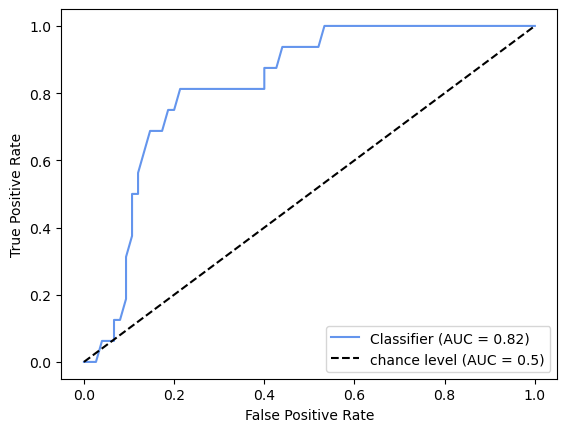

In [26]:
RocCurveDisplay.from_predictions(
    y_test,
    best_model.predict_proba(X_test)[:, 1],
    color="cornflowerblue",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [27]:
# Create predictions
y_pred = best_model.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88        75
         1.0       0.42      0.31      0.36        16

    accuracy                           0.80        91
   macro avg       0.64      0.61      0.62        91
weighted avg       0.78      0.80      0.79        91



In [48]:
models_path = os.path.join("C:/Users/Startklar/Dropbox/PhD VU/Summer Schools/fertility-prediction-challenge/models")
os.makedirs(models_path, exist_ok=True)

# Dump model (don't change the name)
dump(best_model, os.path.join(models_path, "model.joblib"))

['C://Users//Startklar//Dropbox//PhD VU//Summer Schools//fertility-prediction-challenge//models\\model.joblib']

In [49]:
def predict_outcomes(df):
    # Keep 
    keepcols = ['gebjaar', 'geslacht', 'leeftijd2019',
            'aantalhh2019','partner2019', 'sted2019', 'belbezig2019', 
            'nettoink2019', 'oplmet2019', 'herkomstgroep2019',
            'burgstat2019', 'woonvorm2019', 'aantalki2019']
    nomem_encr = df["nomem_encr"]
    
    df = df.loc[:, keepcols]
    
    # Load your trained model from the models directory
    model_path = os.path.join(os.path.dirname(__file__), "..", "models", "model.joblib")
    model = load(model_path)

    # Use your trained model for prediction
    predictions = model.predict(df)
    # Return the result as a Pandas DataFrame with the columns "nomem_encr" and "prediction"
    return pd.concat([nomem_encr, pd.Series(predictions, name="prediction")], axis=1)

In [52]:
or_data = pd.read_csv(path_train, encoding="cp1252", low_memory=False)

In [56]:
__file__ = "C:/Users/Startklar/Dropbox/PhD VU/Summer Schools/fertility-prediction-challenge/models/"
predict_outcomes(or_data)

,nomem_encr,prediction
0,800000.0,1.0
1,800018.0,0.0
2,800021.0,0.0
3,800033.0,0.0
4,800042.0,0.0
...,...,...
9454,899917.0,0.0
9455,899935.0,0.0
9456,899942.0,1.0
9457,899957.0,0.0


In [57]:
import sklearn
sklearn.__version__


'1.2.1'